<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/11-Seq2seq/intro2s2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# dataset gen

import numpy as np
import hashlib
import random
import string

# Generate a random word
def random_word(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

# Generate SHA-256 hash
def sha256_hash(word):
    return hashlib.sha256(word.encode()).hexdigest()

# Create dataset
num_samples = 10000  # Adjust size
max_word_length = 6  # Fixed word length for simplicity

words = [random_word(max_word_length) for _ in range(num_samples)]
hashes = [sha256_hash(word) for word in words]

# Convert to character sequences (for Seq2Seq)
char_set = string.ascii_lowercase + string.digits  # Limited charset
char_to_index = {c: i for i, c in enumerate(char_set, 1)}  # Map chars to numbers
index_to_char = {i: c for c, i in char_to_index.items()}

# Encode words as sequences
def encode_word(word, max_length):
    return [char_to_index[c] for c in word] + [0] * (max_length - len(word))  # Padding

# Encode hashes (convert hex chars to numeric sequences)
def encode_hash(hash_str, max_length=64):  # SHA-256 is 64 hex chars
    return [char_to_index.get(c, 0) for c in hash_str] + [0] * (max_length - len(hash_str))

# Create numerical dataset
X = np.array([encode_hash(h) for h in hashes])
Y = np.array([encode_word(w, max_word_length) for w in words])

# Reshape for LSTM (batch_size, timesteps, features)
X = X.reshape((num_samples, 64, 1))  # 64-timestep hash input
Y = Y.reshape((num_samples, max_word_length, 1))  # word output


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [7]:




# Define Model
encoder_inputs = Input(shape=(64, 1))  # SHA-256 input
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_word_length, 1))
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(char_set) + 1, activation="softmax")  # Predict characters
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])




Epoch 1/50
 50/125 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.0803 - loss: 3.2967

KeyboardInterrupt: 

In [2]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, 256)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, 256)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 128), (None,   │        197,120 │ input_layer[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 128),    │        197,120 │ input_layer_1[0][0],   │
│                           │ (None, 128), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 256)      │         33,024 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 427,264 (1.63 MB)

 Trainable params: 427,264 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

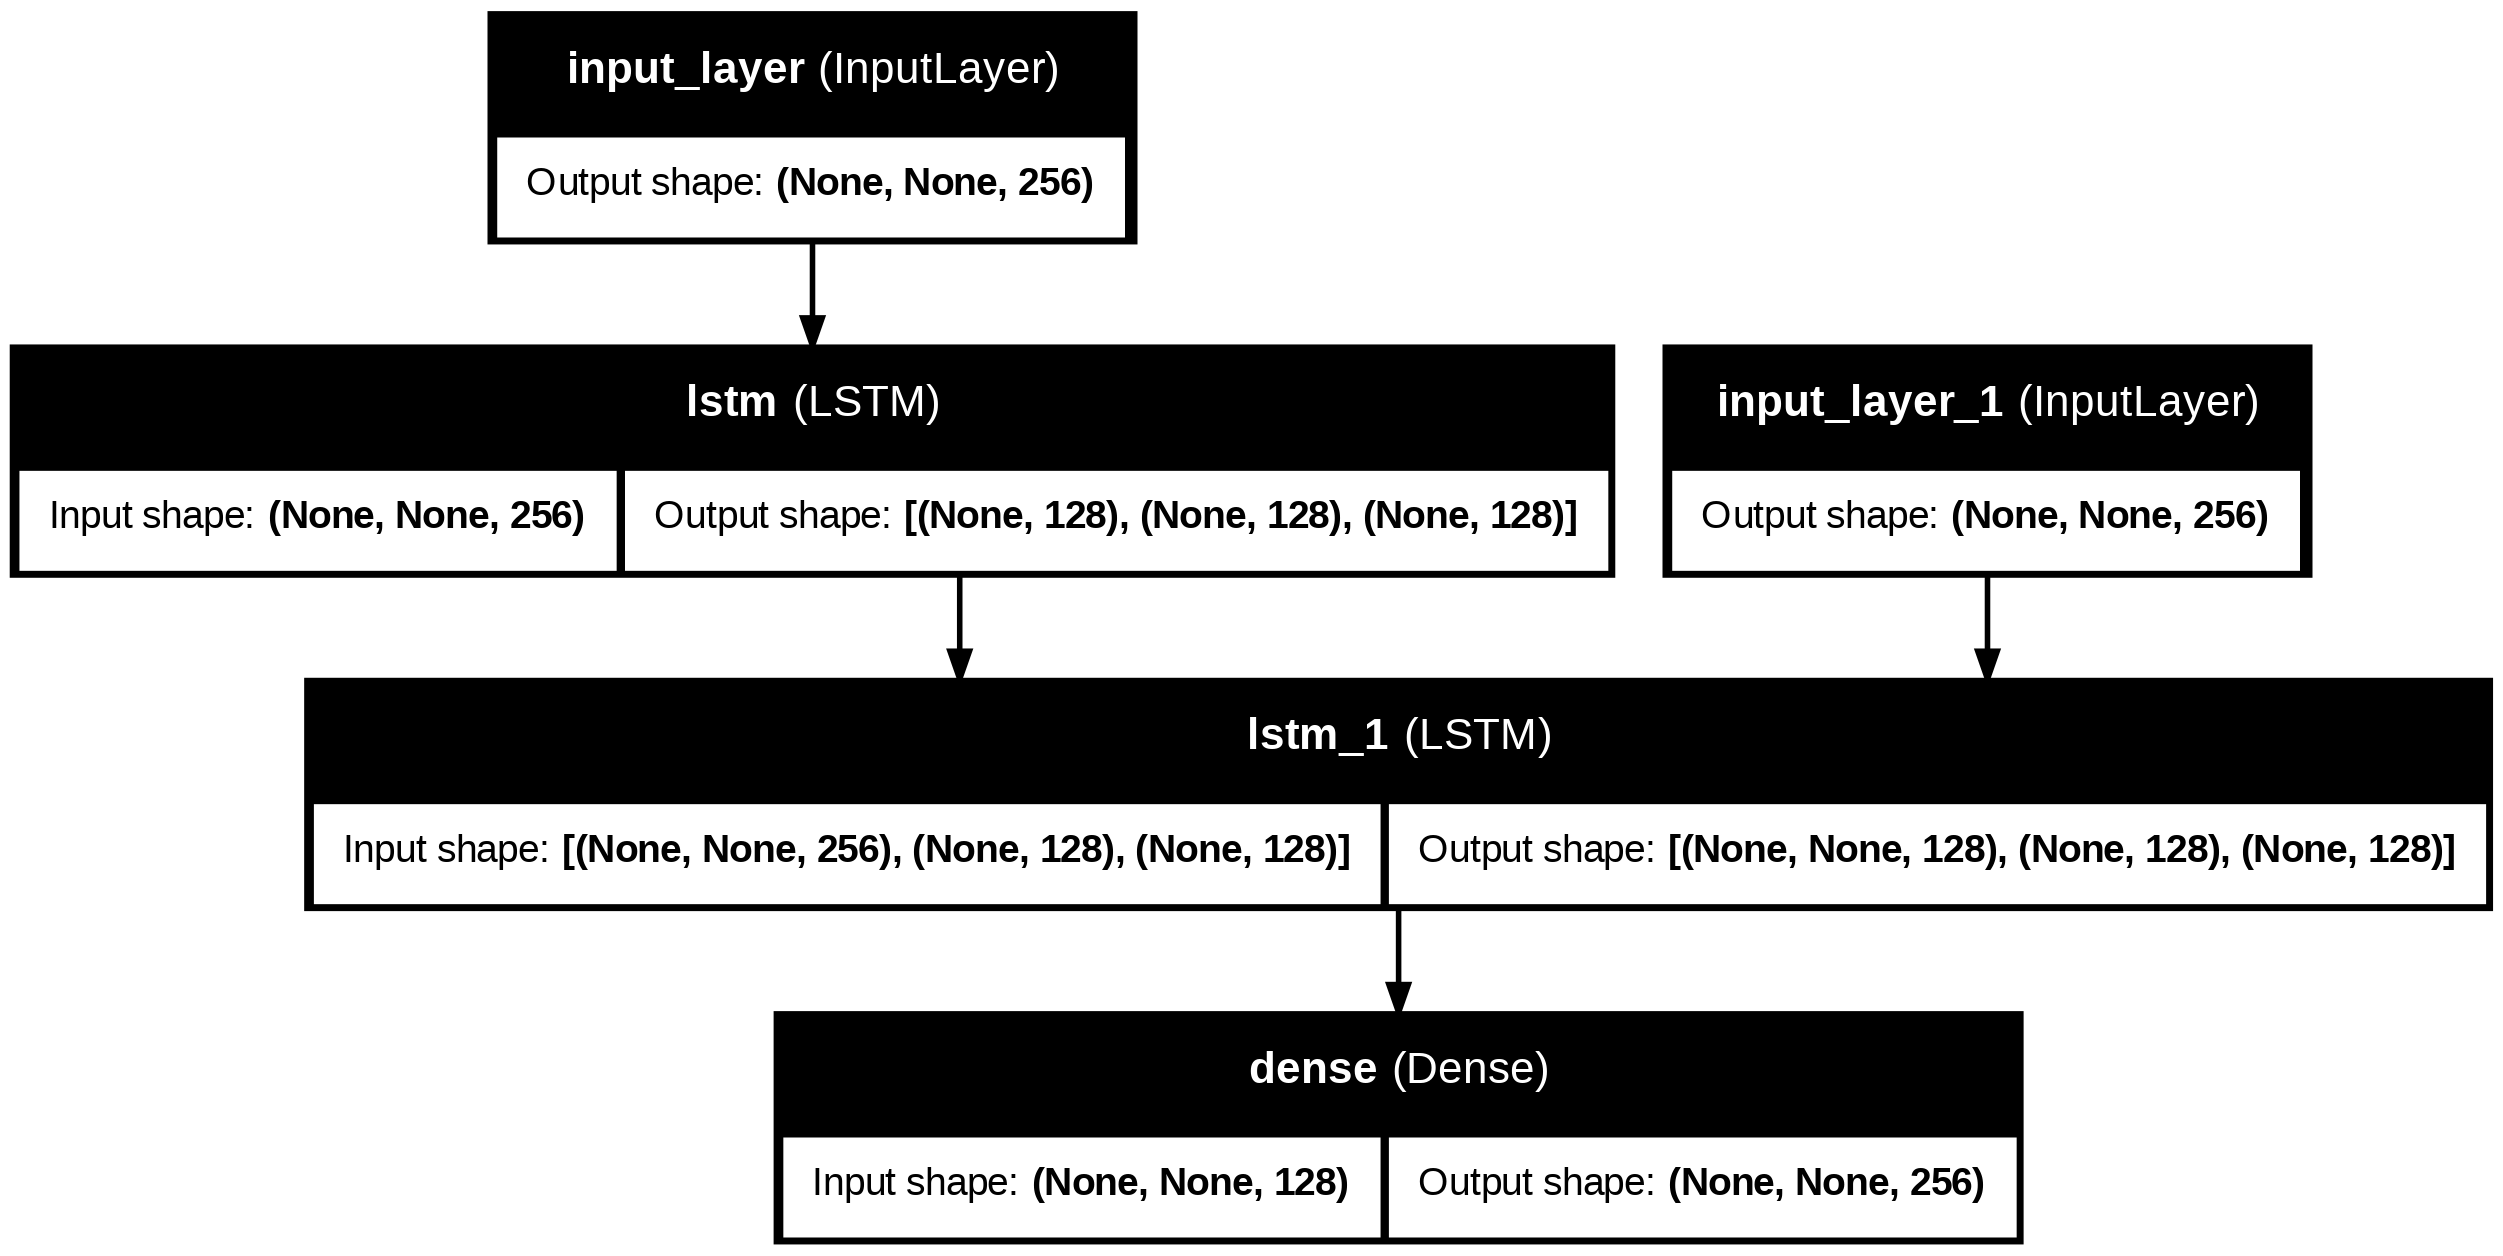

In [3]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
# Train the model
model.fit([X, Y], Y, batch_size=64, epochs=50, validation_split=0.2)